In [125]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [126]:
print(mnist)

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
69995       0       0       0       0       0       0       0       0       0   
69996       0       0       0       0       0       0       0       0       0   
69997       0       0       0       0       0       0       0       0       0   
69998       0       0       0       0       0       0       0       0       0   
69999       0       0       0       0       0       0       0       0       0   

       pixel10  ..

In [127]:
X, Y = mnist['data'], mnist['target']
print(X.shape, Y.shape)

(70000, 784) (70000,)


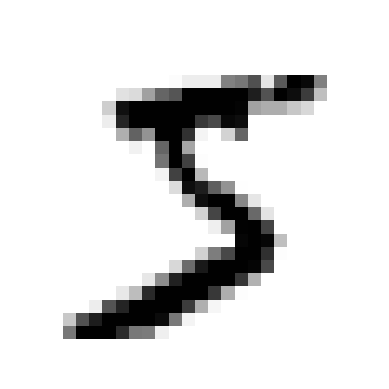

5


In [128]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

some_digit = X.iloc[0]
some_digit_image = np.array(some_digit).reshape(28,28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()
print(Y[0])

In [129]:
Y = Y.astype(np.uint8)

In [130]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]

In [131]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [132]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(x_train, y_train_5)

SGDClassifier()

In [133]:
sgd_clf.predict([X.iloc[0]])

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [134]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3)

for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train.iloc[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train.iloc[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9521
0.96445
0.9613


In [135]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.9553 , 0.9441 , 0.95595])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, x, y = None):
        return self
    def predict(self, x):
        return np.zeros((len(x),1),dtype = bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv = 3)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53022,  1557],
       [  969,  4452]])

In [16]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred))

0.7408886669995007 0.8212506917542889


In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.779002624671916

In [18]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv = 3, method = 'decision_function')

In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
precisions[-5:]

array([1., 1., 1., 1., 1.])

In [20]:
def plot_precision_recall_vs_threshold(precisions, recalls, threshold):
    plt.plot(thresholds, precisions[0:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.legend()
    

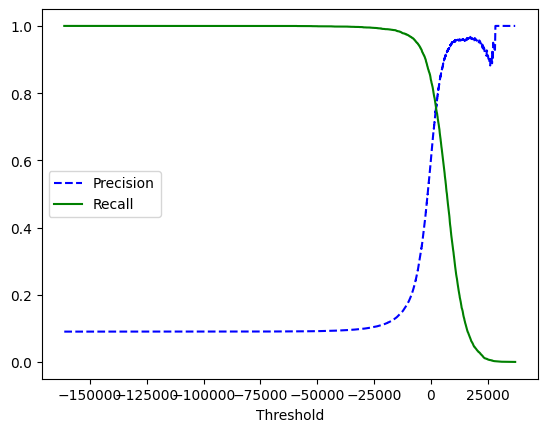

In [21]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

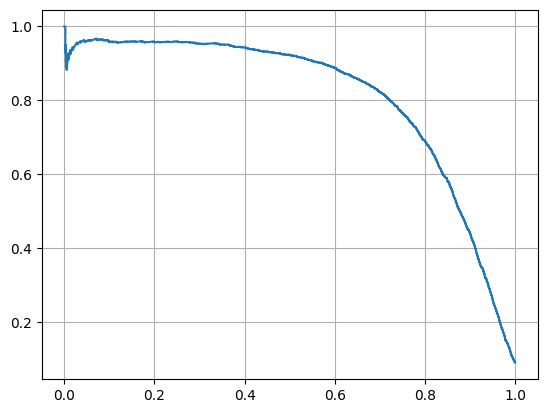

In [136]:
plt.plot(recalls, precisions)
plt.grid(True)
plt.show()

In [23]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

5917.979409895566

In [24]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [25]:
precision_score(y_train_5, y_train_pred_90)

0.9000579374275782

In [26]:
recall_score(y_train_5, y_train_pred_90)

0.5731414868105515

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

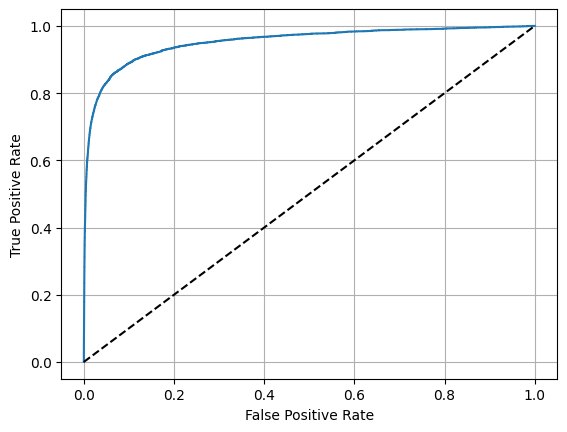

In [28]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, label = None)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9531738134770292

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv = 3, method = 'predict_proba')

In [31]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

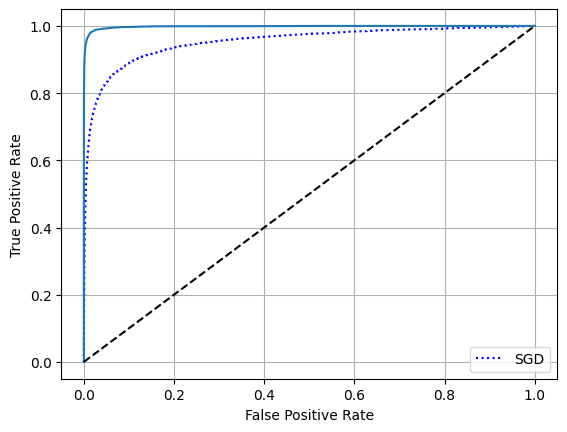

In [137]:
plt.plot(fpr, tpr,'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest,label = 'Random Forest')

plt.legend()
plt.show()

In [33]:
roc_auc_score(y_train_5, y_scores_forest)

0.9981834910999697

In [34]:
cross_val_score(forest_clf, x_train, y_train_5, cv = 3, scoring = 'precision')

array([0.99315068, 0.98736576, 0.98727735])

In [35]:
cross_val_score(forest_clf, x_train, y_train_5, cv = 3, scoring = 'recall')

array([0.88599889, 0.8550083 , 0.86275595])

In [36]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(x_train, y_train)

SVC()

In [37]:
svm_clf.predict([X.iloc[0]])

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [38]:
some_digit = X.iloc[0]
some_digit_score = svm_clf.decision_function([some_digit])
some_digit_score

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [39]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [40]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(x_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [41]:
ovr_clf.predict([some_digit])

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature nam

array([5], dtype=uint8)

In [42]:
len(ovr_clf.estimators_)

10

In [43]:
sgd_clf = OneVsRestClassifier(SGDClassifier())
sgd_clf.fit(x_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier())

In [44]:
sgd_clf.predict([some_digit])

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid 

array([5], dtype=uint8)

In [45]:
sgd_clf.decision_function([some_digit])

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid 

array([[-21032.35081959, -24599.5562881 , -10052.20838149,
         -1802.75303536, -21606.81685695,    757.5362881 ,
        -25274.98136816, -18365.06040115, -13781.42286663,
         -9802.51646476]])

In [46]:
cross_val_score(sgd_clf, x_train, y_train, cv = 3, scoring = 'accuracy')

array([0.8784, 0.8865, 0.8544])

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_trained_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, X_trained_scaled, y_train, cv = 3, scoring = 'accuracy')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.9026, 0.8953, 0.9025])

In [141]:
y_train_pred = cross_val_predict(sgd_clf, X_trained_scaled, y_train, cv = 3)
conf_mat = confusion_matrix(y_train, y_train_pred) 
print(conf_mat)

[[5568    0   22    6    8   42   35    5  236    1]
 [   0 6397   38   23    4   44    4    8  212   12]
 [  28   27 5242   91   69   26   67   39  358   11]
 [  23   17  119 5210    2  215   26   39  408   72]
 [  10   14   48   10 5202   12   34   25  324  163]
 [  27   15   31  172   51 4456   75   14  519   61]
 [  29   15   45    2   41   93 5560    3  129    1]
 [  20    9   52   24   50   13    3 5698  189  207]
 [  17   60   48   88    3  122   26   11 5433   43]
 [  20   18   30   64  117   33    1  175  362 5129]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


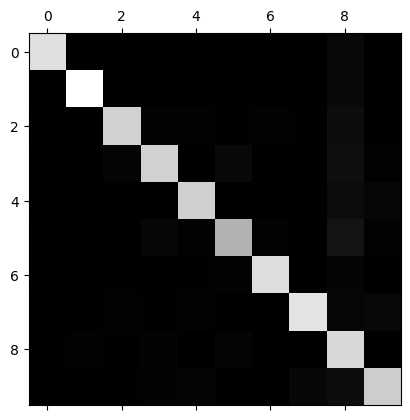

In [49]:
plt.matshow(conf_mat, cmap = plt.cm.gray)
plt.show()

In [50]:
row_sum = conf_mat.sum(axis = 1, keepdims = True)
norm_conf_mat = conf_mat/row_sum
norm_conf_mat

array([[9.43103157e-01, 0.00000000e+00, 3.71433395e-03, 1.01300017e-03,
        1.51950025e-03, 7.25983454e-03, 5.90916765e-03, 1.01300017e-03,
        3.62991727e-02, 1.68833361e-04],
       [0.00000000e+00, 9.50163156e-01, 5.48798576e-03, 3.85642243e-03,
        5.93295758e-04, 6.37792940e-03, 5.93295758e-04, 1.18659152e-03,
        3.01097597e-02, 1.63156333e-03],
       [4.53172205e-03, 4.36388050e-03, 8.80496811e-01, 1.61127895e-02,
        1.19167506e-02, 4.36388050e-03, 1.17489090e-02, 6.37797919e-03,
        5.84088620e-02, 1.67841558e-03],
       [3.75142717e-03, 2.77279400e-03, 1.92464525e-02, 8.55488501e-01,
        3.26211059e-04, 3.35997390e-02, 3.91453270e-03, 6.68732670e-03,
        6.26325232e-02, 1.15804926e-02],
       [2.05409106e-03, 2.39643958e-03, 8.38753851e-03, 1.88291681e-03,
        8.91475522e-01, 1.88291681e-03, 5.99109894e-03, 4.45053064e-03,
        5.22081479e-02, 2.92707977e-02],
       [5.16509869e-03, 2.76701716e-03, 5.53403431e-03, 3.15439956e-02,
   

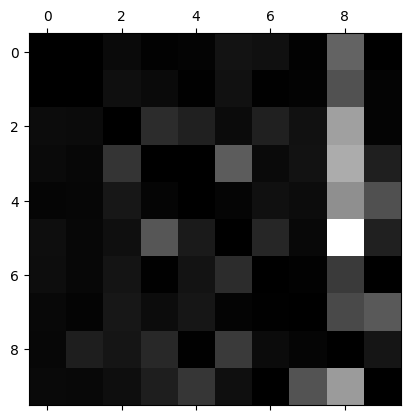

In [51]:
np.fill_diagonal(norm_conf_mat, 0)
plt.matshow(norm_conf_mat, cmap = plt.cm.gray)
plt.show()

In [70]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier()

In [74]:
knn_clf.predict([some_digit])

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [76]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [79]:
X_train = x_train
X_test = x_test
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

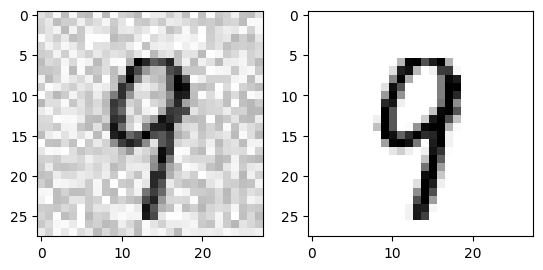

In [119]:
some_digit = X_train.iloc[random]
some_digit_image = np.array(some_digit).reshape(28,28)
some_digit = X_train_mod.iloc[random]
some_digit_noisy_image = np.array(some_digit).reshape(28,28)
plt.subplot(1,2,1)
plt.imshow(some_digit_noisy_image, cmap = 'binary')
plt.subplot(1,2,2)
plt.imshow(some_digit_image, cmap = 'binary')
plt.show()

In [120]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

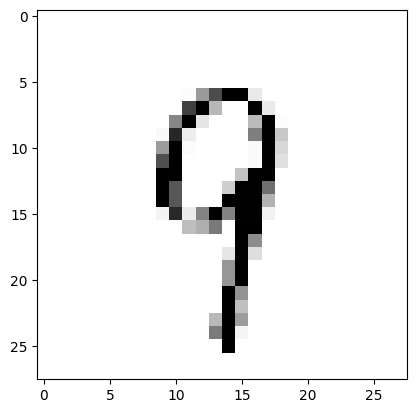

In [122]:
clean_digit = knn_clf.predict(pd.DataFrame(X_train_mod.iloc[random]).T)
plt.imshow(np.array(clean_digit).reshape(28,28), cmap = 'binary')